# Results & Performance

## Reading data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from typing import Any

pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)        # Sin límite de ancho
pd.set_option('display.max_colwidth', 50)   # Ancho máximo de columna


import pickle
import joblib
from datetime import datetime
import os

def load_experiment_results(file_path):
    """
    Carga resultados guardados previamente.
    
    Parameters:
    -----------
    file_path : str
        Ruta al archivo pickle guardado
    
    Returns:
    --------
    dict
        Diccionario con 'summary' y 'full_results' (o el contenido completo)
    """
    with open(file_path, 'rb') as f:
        resultados = pickle.load(f)
    
    print(f"✅ Resultados cargados desde: {file_path}")
    
    # Si es el resultado completo, devolverlo tal cual
    if isinstance(resultados, dict) and ('summary' in resultados or 'full_results' in resultados):
        if 'summary' in resultados:
            print(f"   - Summary: {len(resultados['summary'])} experimentos")
        if 'full_results' in resultados:
            print(f"   - Full results: {len(resultados['full_results'])} experimentos")
        return resultados
    else:
        # Si es solo full_results, devolverlo envuelto
        return {'full_results': resultados}

In [2]:
import numpy as np
import pandas as pd

def prepare_features_for_scoring(df_pop, features_list, categorical_features, algorithm, encoder, encoder_type):
    X = df_pop[features_list].copy()

    # CatBoost: puede recibir categóricas crudas (idealmente tipo str o category)
    if algorithm.lower() == "catboost":
        # opcional: asegurar dtype consistente
        for c in categorical_features or []:
            if c in X.columns:
                X[c] = X[c].astype("str")
        return X

    # XGBoost / LightGBM: si hubo encoder, aplícalo
    if encoder is not None:
        # WOEEncoder de category_encoders
        if encoder_type.lower() == "woe":
            X = encoder.transform(X)
        # dict de LabelEncoder (tu implementación actual)
        elif encoder_type.lower() == "label":
            for c, le in encoder.items():
                if c in X.columns:
                    # IMPORTANTE: esto truena si hay categorías nuevas
                    X[c] = le.transform(X[c].astype(str))
    return X


def score_population(df_pop, experiment_result):
    model = experiment_result["model"]
    encoder = experiment_result["encoder"]
    info = experiment_result["experiment_info"]

    features_list = experiment_result["numeric_features"] + experiment_result["categorical_features"]
    categorical_features = experiment_result["categorical_features"]
    algorithm = info["algorithm"]
    encoder_type = info.get("encoder_type", "native")

    X = prepare_features_for_scoring(
        df_pop=df_pop,
        features_list=features_list,
        categorical_features=categorical_features,
        algorithm=algorithm,
        encoder=encoder,
        encoder_type=encoder_type if isinstance(encoder_type, str) else "native"
    )

    # Probabilidad clase 1
    proba = model.predict_proba(X)[:, 1]
    return proba



import json
def load_dict_with_lists(file_path):
    """
    Carga un diccionario guardado previamente.
    
    Parameters:
    -----------
    file_path : str
        Ruta al archivo guardado
    
    Returns:
    --------
    dict
        Diccionario cargado
    """
    import os
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")
    
    # Detectar formato por extensión
    ext = os.path.splitext(file_path)[1].lower()
    
    if ext == '.json':
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✅ Diccionario cargado desde JSON: {file_path}")
    
    elif ext in ['.pkl', '.pickle']:
        import pickle
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        print(f"✅ Diccionario cargado desde Pickle: {file_path}")
    
    else:
        raise ValueError(f"Extensión '{ext}' no reconocida. Use .json, .pkl o .pickle")
    
    return data

# Ej

In [3]:
df_old02 = pd.read_csv("../data/data_train_oot_round01.csv")

results_from_pickle= load_experiment_results(file_path="../results/experimentos_catboost_round01_complete_20260115_124834.pkl")
results_from_pickle.keys()

/var/folders/kl/z4y0w58x06v4841j8095kd0c0000gq/T/ipykernel_80577/1267031817.py:1: DtypeWarning: Columns (20,50,60,130,131,132,135,136,137,140) have mixed types. Specify dtype option on import or set low_memory=False.
  df_old02 = pd.read_csv("../data/data_train_oot_round01.csv")


✅ Resultados cargados desde: ../results/experimentos_catboost_round01_complete_20260115_124834.pkl
   - Summary: 4 experimentos
   - Full results: 4 experimentos


dict_keys(['summary', 'full_results'])

In [4]:
config_cargado = load_dict_with_lists(file_path='../config/columnas_config_round01.json')
key_columns = config_cargado['key_columns']
list_for_metrics = config_cargado['list_for_metrics']
list_targets = config_cargado['list_targets']
selected_features = config_cargado['selected_features']
pre_categorical_features = config_cargado['pre_categorical_features']

✅ Diccionario cargado desde JSON: ../config/columnas_config_round01.json


### To remember

In order to make a fair comparision with the same dataset, I'll check the performance for the intersections of the OOTs samples which is between `2015-08-01` and `2016-02-29`

In [5]:
df_pop = df_old02[(
    (
        df_old02['issue_d'] >= '2015-08-01'
        #) & (
        #    df_old02['issue_d'] <= '2016-02-29' not necesary because the df_old02 is already filtered until that date
        )
)]
scores = pd.DataFrame(index=df_pop.index).merge(
    df_pop[list(set(key_columns+['issue_d_month','fico_range_mean']+[
        x for x in df_pop.columns if x.startswith('mature_at')
        ]+list_for_metrics))],
    left_index=True,
    right_index=True
)

# Usar full_results en lugar de resultados_comparativos directamente
# resultados_comparativos ahora es un dict con 'summary' y 'full_results'
for i, res in enumerate(results_from_pickle['full_results'], 1):
    if res is None:
        print(f"⚠️  Saltando experimento {i}: hubo un error durante el entrenamiento")
        continue
    name = f"{res['experiment_info']['algorithm']}_{i}"
    scores[name] = score_population(df_pop, res)

# opcional: promediar / comparar
#scores["avg"] = scores.mean(axis=1)
experiments_01 = [x for x in scores.columns if x not in df_old02.columns]
scores


,pre_LR__discounts,is_paid_strict,pre_LR__strict,mature_at_30dpd,fico_range_mean,int_rate,post_20131105,pre_LR__30dpd,is_paid_prior_30dpd,installment,id,collection_recovery_fee,total_rec_prncp,issue_d,total_rec_late_fee,total_pymnt,issue_d_month,total_rec_int,profit,term,loan_amnt,member_id,mature_at_default,loan_status,catboost_1,catboost_2,catboost_3,catboost_4
0,0.00,1.0,0.00,True,677.0,13.99,True,0.00,1.0,123.03,68407277,0.0000,3600.00,2015-12-01,0.0,4421.723917,2015-12,821.72,821.723917,36 months,3600.0,NaN,True,Fully Paid,0.584004,0.864791,0.598268,0.874146
1,0.00,1.0,0.00,True,717.0,11.99,True,0.00,1.0,820.28,68355089,0.0000,24700.00,2015-12-01,0.0,25679.660000,2015-12,979.66,979.660000,36 months,24700.0,NaN,True,Fully Paid,0.563752,0.838408,0.608517,0.870628
2,0.00,1.0,0.00,True,697.0,10.78,True,0.00,1.0,432.66,68341763,0.0000,20000.00,2015-12-01,0.0,22705.924294,2015-12,2705.92,2705.924294,60 months,20000.0,NaN,True,Fully Paid,0.690935,0.903198,0.717971,0.908592
3,0.00,1.0,0.00,True,697.0,22.45,True,0.00,1.0,289.91,68476807,0.0000,10400.00,2015-12-01,0.0,11740.500000,2015-12,1340.50,1340.500000,60 months,10400.0,NaN,True,Fully Paid,0.401271,0.751586,0.391132,0.728915
4,0.00,1.0,0.00,True,692.0,13.44,True,0.00,1.0,405.18,68426831,0.0000,11950.00,2015-12-01,0.0,13708.948530,2015-12,1758.95,1758.948530,36 months,11950.0,NaN,True,Fully Paid,0.538870,0.826594,0.593836,0.828337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440400,0.00,1.0,0.00,True,697.0,9.17,True,0.00,1.0,191.28,66055600,0.0000,6000.00,2016-01-01,0.0,6903.429166,2016-01,903.43,903.429166,36 months,6000.0,NaN,True,Fully Paid,0.519913,0.820479,0.514976,0.814348
440401,0.00,1.0,0.00,True,697.0,7.89,True,0.00,1.0,187.72,65854936,0.0000,6000.00,2016-01-01,0.0,6755.041951,2016-01,755.04,755.041951,36 months,6000.0,NaN,True,Fully Paid,0.545439,0.845474,0.550617,0.839800
440402,8850.25,0.0,8850.25,True,672.0,13.18,True,8850.25,0.0,328.98,66141895,210.1878,5549.75,2016-01-01,0.0,10368.610000,2016-01,3651.15,-4031.390000,60 months,14400.0,NaN,True,Charged Off,0.422340,0.713526,0.383367,0.723441
440403,0.00,1.0,0.00,True,682.0,15.41,True,0.00,1.0,1187.21,65673209,0.0000,34050.00,2016-01-01,0.0,42914.121754,2016-01,8864.12,8864.121754,36 months,34050.0,NaN,True,Fully Paid,0.494789,0.816043,0.507818,0.822744


## LR & DR & profit vs Score's bin

In [6]:
def calculate_bins(scores_df, score_columns=None, n_bins=5):
    """
    Calcula bines de igual frecuencia (igual proporción de población) para las columnas de scores.
    
    Parameters:
    -----------
    scores_df : pandas.DataFrame
        DataFrame con los scores y otras columnas
    score_columns : list, optional
        Lista de nombres de columnas de scores. Si None, se detectan automáticamente
        (columnas que contienen nombres de algoritmos como 'xgboost', 'lgbm', 'catboost')
    n_bins : int
        Número de bines de igual frecuencia a crear (default: 5)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame original con columnas adicionales '{score_name}_bin' para cada score
    """
    df = scores_df.copy()
    
    # Identificar columnas de scores si no se proporcionan
    if score_columns is None:
        # Detectar columnas que parecen ser scores (contienen nombres de algoritmos)
        algorithm_names = ['xgboost', 'lgbm', 'lightgbm', 'catboost']
        score_columns = [
            col for col in df.columns 
            if any(alg in col.lower() for alg in algorithm_names) and 
               col not in ['id', 'issue_d'] and  # Excluir columnas clave
               df[col].dtype in [np.float64, np.float32, np.int64, np.int32]  # Solo numéricas
        ]
    
    if len(score_columns) == 0:
        print("⚠️  No se encontraron columnas de scores. Verifica los nombres de las columnas.")
        return df
    
    print(f"📊 Calculando bines para {len(score_columns)} columnas de scores:")
    for col in score_columns:
        print(f"  - {col}")
    
    # Calcular bines de igual frecuencia para cada columna de score
    for col in score_columns:
        if col not in df.columns:
            print(f"⚠️  Columna {col} no encontrada en el DataFrame")
            continue
        
        # Calcular bines de igual frecuencia (quantiles)
        try:
            df[f'{col}_bin_str'] = pd.qcut(
                df[col], 
                q=n_bins, 
                labels=[f'Bin_{i+1}' for i in range(n_bins)],
                duplicates='drop'  # Si hay valores duplicados en los límites, los agrupa
            )
        except ValueError as e:
            # Si hay muchos valores duplicados, usar cut en lugar de qcut
            print(f"⚠️  No se pudieron crear {n_bins} bines únicos para {col}. Usando cut() en su lugar.")
            df[f'{col}_bin_str'] = pd.cut(
                df[col],
                bins=n_bins,
                labels=[f'Bin_{i+1}' for i in range(n_bins)],
                duplicates='drop'
            )
    
        df[f'{col}_bin'] = df[f'{col}_bin_str'].str.replace('Bin_', '').astype(int)
        
    print(f"\n✅ Bines calculados exitosamente ({n_bins} bines de igual frecuencia por score)")
    
    return df

# Ejemplo de uso:
scores_with_bins = calculate_bins(scores,score_columns=['fico_range_mean']+experiments_01, n_bins=5)
scores_with_bins

📊 Calculando bines para 5 columnas de scores:
  - fico_range_mean
  - catboost_1
  - catboost_2
  - catboost_3
  - catboost_4

✅ Bines calculados exitosamente (5 bines de igual frecuencia por score)


,pre_LR__discounts,is_paid_strict,pre_LR__strict,mature_at_30dpd,fico_range_mean,int_rate,post_20131105,pre_LR__30dpd,is_paid_prior_30dpd,installment,id,collection_recovery_fee,total_rec_prncp,issue_d,total_rec_late_fee,total_pymnt,issue_d_month,total_rec_int,profit,term,loan_amnt,member_id,mature_at_default,loan_status,catboost_1,catboost_2,catboost_3,catboost_4,fico_range_mean_bin_str,fico_range_mean_bin,catboost_1_bin_str,catboost_1_bin,catboost_2_bin_str,catboost_2_bin,catboost_3_bin_str,catboost_3_bin,catboost_4_bin_str,catboost_4_bin
0,0.00,1.0,0.00,True,677.0,13.99,True,0.00,1.0,123.03,68407277,0.0000,3600.00,2015-12-01,0.0,4421.723917,2015-12,821.72,821.723917,36 months,3600.0,NaN,True,Fully Paid,0.584004,0.864791,0.598268,0.874146,Bin_2,2,Bin_4,4,Bin_4,4,Bin_4,4,Bin_4,4
1,0.00,1.0,0.00,True,717.0,11.99,True,0.00,1.0,820.28,68355089,0.0000,24700.00,2015-12-01,0.0,25679.660000,2015-12,979.66,979.660000,36 months,24700.0,NaN,True,Fully Paid,0.563752,0.838408,0.608517,0.870628,Bin_4,4,Bin_4,4,Bin_3,3,Bin_4,4,Bin_4,4
2,0.00,1.0,0.00,True,697.0,10.78,True,0.00,1.0,432.66,68341763,0.0000,20000.00,2015-12-01,0.0,22705.924294,2015-12,2705.92,2705.924294,60 months,20000.0,NaN,True,Fully Paid,0.690935,0.903198,0.717971,0.908592,Bin_3,3,Bin_5,5,Bin_5,5,Bin_5,5,Bin_5,5
3,0.00,1.0,0.00,True,697.0,22.45,True,0.00,1.0,289.91,68476807,0.0000,10400.00,2015-12-01,0.0,11740.500000,2015-12,1340.50,1340.500000,60 months,10400.0,NaN,True,Fully Paid,0.401271,0.751586,0.391132,0.728915,Bin_3,3,Bin_2,2,Bin_2,2,Bin_2,2,Bin_2,2
4,0.00,1.0,0.00,True,692.0,13.44,True,0.00,1.0,405.18,68426831,0.0000,11950.00,2015-12-01,0.0,13708.948530,2015-12,1758.95,1758.948530,36 months,11950.0,NaN,True,Fully Paid,0.538870,0.826594,0.593836,0.828337,Bin_3,3,Bin_3,3,Bin_3,3,Bin_4,4,Bin_3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440400,0.00,1.0,0.00,True,697.0,9.17,True,0.00,1.0,191.28,66055600,0.0000,6000.00,2016-01-01,0.0,6903.429166,2016-01,903.43,903.429166,36 months,6000.0,NaN,True,Fully Paid,0.519913,0.820479,0.514976,0.814348,Bin_3,3,Bin_3,3,Bin_3,3,Bin_3,3,Bin_3,3
440401,0.00,1.0,0.00,True,697.0,7.89,True,0.00,1.0,187.72,65854936,0.0000,6000.00,2016-01-01,0.0,6755.041951,2016-01,755.04,755.041951,36 months,6000.0,NaN,True,Fully Paid,0.545439,0.845474,0.550617,0.839800,Bin_3,3,Bin_3,3,Bin_4,4,Bin_3,3,Bin_4,4
440402,8850.25,0.0,8850.25,True,672.0,13.18,True,8850.25,0.0,328.98,66141895,210.1878,5549.75,2016-01-01,0.0,10368.610000,2016-01,3651.15,-4031.390000,60 months,14400.0,NaN,True,Charged Off,0.422340,0.713526,0.383367,0.723441,Bin_1,1,Bin_2,2,Bin_1,1,Bin_1,1,Bin_1,1
440403,0.00,1.0,0.00,True,682.0,15.41,True,0.00,1.0,1187.21,65673209,0.0000,34050.00,2016-01-01,0.0,42914.121754,2016-01,8864.12,8864.121754,36 months,34050.0,NaN,True,Fully Paid,0.494789,0.816043,0.507818,0.822744,Bin_2,2,Bin_3,3,Bin_3,3,Bin_3,3,Bin_3,3


In [7]:
score_columns=['fico_range_mean']+experiments_01

dict_to_agg_strict = {
        'id':'count',
        'installment':'mean',
        'int_rate':'mean',
        #'term_int':'mean',
        'is_paid_prior_30dpd':'mean',
        'is_paid_strict':'mean',
        'loan_amnt':'sum',
        'pre_LR__30dpd':'sum',
        'pre_LR__strict':'sum',
        'pre_LR__discounts':'sum',
        'profit':'sum',
        'score_mean':'mean'
        }
        
gb_all = pd.DataFrame()
for scoretmp in score_columns:
    print(f"{scoretmp}")
    bintmp =f"{scoretmp}_bin"
    print(f"{bintmp}")
    gb_tmp = scores_with_bins.rename(columns={scoretmp:'score_mean'}).groupby(
        ['mature_at_default',bintmp]
        ).agg(
        dict_to_agg_strict
    ).assign(
        DR_30dpd = lambda x: 1-x['is_paid_prior_30dpd'],
        DR_strict = lambda x: 1-x['is_paid_strict'],
        LR_30dpd = lambda x: x['pre_LR__30dpd']/x['loan_amnt'],
        LR_strict = lambda x: x['pre_LR__strict']/x['loan_amnt'],
        LR_discounts = lambda x: x['pre_LR__discounts']/x['loan_amnt'],
        profit_mean = lambda x: x['profit']/x['id'],
        score = scoretmp
    )
    gb_all = pd.concat([gb_all,gb_tmp],axis=0)

gb_all = gb_all.reset_index().rename(columns={'level_1':'bin_score'})
gb_mature_at_default = gb_all[gb_all['mature_at_default']==True]
gb_mature_at_default

fico_range_mean
fico_range_mean_bin
catboost_1
catboost_1_bin
catboost_2
catboost_2_bin
catboost_3
catboost_3_bin
catboost_4
catboost_4_bin


,mature_at_default,bin_score,id,installment,int_rate,is_paid_prior_30dpd,is_paid_strict,loan_amnt,pre_LR__30dpd,pre_LR__strict,pre_LR__discounts,profit,score_mean,DR_30dpd,DR_strict,LR_30dpd,LR_strict,LR_discounts,profit_mean,score
5,True,1,65461,403.543588,13.879588,0.744397,0.744397,852882775.0,1.732900e+08,1.732900e+08,1.732900e+08,3.636795e+06,666.880692,0.255603,0.255603,0.203181,0.203181,0.203181,55.556669,fico_range_mean
6,True,2,37132,434.315552,13.165747,0.763519,0.763519,528028650.0,9.665927e+07,9.665927e+07,9.665927e+07,6.321871e+06,679.464855,0.236481,0.236481,0.183057,0.183057,0.183057,170.253975,fico_range_mean
7,True,3,44876,454.063161,12.342322,0.796283,0.796283,676707500.0,1.059359e+08,1.059359e+08,1.059359e+08,1.650083e+07,691.763014,0.203717,0.203717,0.156546,0.156546,0.156546,367.698329,fico_range_mean
8,True,4,42733,473.338301,11.231631,0.833033,0.833033,681624975.0,8.346066e+07,8.346066e+07,8.346066e+07,2.826769e+07,708.753563,0.166967,0.166967,0.122444,0.122444,0.122444,661.495525,fico_range_mean
9,True,5,44542,474.242305,9.321789,0.892461,0.892461,725229250.0,5.920009e+07,5.920009e+07,5.920009e+07,3.581972e+07,748.175015,0.107539,0.107539,0.081629,0.081629,0.081629,804.178582,fico_range_mean
15,True,1,46870,391.474255,15.472404,0.649349,0.649349,586813700.0,1.683337e+08,1.683337e+08,1.683337e+08,-3.307402e+07,0.335281,0.350651,0.350651,0.286861,0.286861,0.286861,-705.654286,catboost_1
16,True,2,46928,413.047106,13.571445,0.758566,0.758566,629902900.0,1.230348e+08,1.230348e+08,1.230348e+08,4.517536e+06,0.433331,0.241434,0.241434,0.195323,0.195323,0.195323,96.265252,catboost_1
17,True,3,46926,440.391702,12.268125,0.814794,0.814794,682631325.0,1.019277e+08,1.019277e+08,1.019277e+08,2.260441e+07,0.512054,0.185206,0.185206,0.149316,0.149316,0.149316,481.703342,catboost_1
18,True,4,46988,475.239323,10.812244,0.861241,0.861241,752205250.0,7.960964e+07,7.960964e+07,7.960965e+07,4.187451e+07,0.604244,0.138759,0.138759,0.105835,0.105835,0.105835,891.174527,catboost_1
19,True,5,47032,500.564243,8.519234,0.923371,0.923371,812919975.0,4.564005e+07,4.564005e+07,4.564005e+07,5.462447e+07,0.752944,0.076629,0.076629,0.056143,0.056143,0.056143,1161.431952,catboost_1


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def plot_metrics_by_score(df, metrics_list, x_column='Bin_1', score_column='score', 
                          save_path=None, figsize=(10, 6)):
    """
    Crea lineplots para múltiples métricas con hue por score.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame con los datos agrupados por bins
    metrics_list : list
        Lista de nombres de columnas de métricas a graficar
    x_column : str
        Nombre de la columna para el eje X (default: 'Bin_1', asumiendo que hay una columna de bin)
    score_column : str
        Nombre de la columna que contiene los nombres de los scores (default: 'score')
    save_path : str, optional
        Directorio donde guardar las imágenes. Si None, solo muestra las gráficas
    figsize : tuple
        Tamaño de las figuras (default: (10, 6))
    """
    # Configurar estilo sin spines, grids, etc.
    sns.set_style("white")
    
    # Crear paleta de azules
    n_scores = df[score_column].nunique()
    blues_palette = sns.color_palette("Blues", n_colors=n_scores)
    
    # Ordenar los bins si es posible (para que el eje X tenga orden lógico)
    if x_column in df.columns:
        # Intentar ordenar por nombre de bin si son Bin_1, Bin_2, etc.
        if df[x_column].dtype == 'object':
            try:
                bin_order = sorted(df[x_column].unique(), 
                                 key=lambda x: int(x.split('_')[1]) if '_' in str(x) else x)
            except:
                bin_order = sorted(df[x_column].unique())
        else:
            bin_order = sorted(df[x_column].unique())
    else:
        bin_order = None
    
    # Crear una gráfica por cada métrica
    for metric in metrics_list:
        if metric not in df.columns:
            print(f"⚠️  Métrica '{metric}' no encontrada en el DataFrame. Saltando...")
            continue
        
        # Crear figura
        fig, ax = plt.subplots(figsize=figsize, facecolor='white')
        
        # Crear lineplot
        if bin_order:
            sns.lineplot(
                data=df,
                x=x_column,
                y=metric,
                hue=score_column,
                marker='o',  # Puntos en cada coordenada
                markersize=8,
                linewidth=2,
                palette=blues_palette,
                ax=ax,
                sort=False  # Mantener el orden de los bins
            )
        else:
            sns.lineplot(
                data=df,
                x=x_column,
                y=metric,
                hue=score_column,
                marker='o',  # Puntos en cada coordenada
                markersize=8,
                linewidth=2,
                palette=blues_palette,
                ax=ax
            )
        
        # Aplicar estilo: sin spines, sin grids, pero con labels de ejes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(False)
        
        # Configurar ticks del eje X (números de bines: 1, 2, 3, ..., n_bins)
        try:
            if x_column in df.columns:
                unique_bins = df[x_column].unique()
            else:
                # Intentar obtener del índice si es MultiIndex
                unique_bins = df.index.get_level_values(x_column).unique() if hasattr(df.index, 'get_level_values') else []
            
            # Ordenar los bines
            if len(unique_bins) > 0:
                try:
                    # Intentar ordenar por número si son Bin_1, Bin_2, etc.
                    unique_bins = sorted(unique_bins, 
                                        key=lambda x: int(str(x).split('_')[1]) if '_' in str(x) and str(x).split('_')[1].isdigit() else str(x))
                except:
                    unique_bins = sorted(unique_bins)
                
                # Configurar ticks: números 1, 2, 3, ..., n_bins
                ax.set_xticks(range(len(unique_bins)))
                #ax.set_xticklabels([str(i+1) for i in range(len(unique_bins))], fontsize=10)
                ax.set_xticklabels([str(i) for i in range(len(unique_bins))], fontsize=10)
        except Exception as e:
            # Si hay error, no mostrar ticks en X
            pass
        
        # Configurar ticks del eje Y (algunos valores: min, max y algunos intermedios)
        y_values = df[metric].dropna()
        if len(y_values) > 0:
            y_min = y_values.min()
            y_max = y_values.max()
            # Crear 5 ticks aproximadamente (min, max y 3 intermedios)
            n_ticks = 5
            y_ticks = np.linspace(y_min, y_max, n_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{val:.2f}' if abs(val) < 1 else f'{val:.1f}' for val in y_ticks], fontsize=10)
        
        # Agregar labels a los ejes
        ax.set_xlabel(x_column, fontsize=12, fontweight='normal')
        ax.set_ylabel(metric, fontsize=12, fontweight='normal')
        
        # Título con el nombre de la métrica
        ax.set_title(metric, fontsize=14, fontweight='bold', pad=20)
        
        # Ajustar layout
        plt.tight_layout()
        
        # Guardar o mostrar
        if save_path:
            import os
            os.makedirs(save_path, exist_ok=True)
            filename = os.path.join(save_path, f'{metric}.png')
            plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"✅ Gráfica guardada: {filename}")
            plt.close()
        else:
            plt.show()
    
    if save_path:
        print(f"\n✅ Todas las gráficas guardadas en: {save_path}")


def plot_metrics_by_score_grid(df, metrics_list, x_column='Bin_1', score_column='score', 
                               figsize_per_plot=(6, 4)):
    """
    Crea lineplots para múltiples métricas en un grid de 2 columnas con hue por score.
    Muestra todas las gráficas en el notebook.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame con los datos agrupados por bins
    metrics_list : list
        Lista de nombres de columnas de métricas a graficar
    x_column : str
        Nombre de la columna para el eje X (default: 'Bin_1', asumiendo que hay una columna de bin)
    score_column : str
        Nombre de la columna que contiene los nombres de los scores (default: 'score')
    figsize_per_plot : tuple
        Tamaño de cada subplot individual (default: (6, 4))
    """
    # Configurar estilo sin spines, grids, etc.
    sns.set_style("white")
    
    # Filtrar métricas que existen en el DataFrame
    valid_metrics = [m for m in metrics_list if m in df.columns]
    if len(valid_metrics) != len(metrics_list):
        missing = set(metrics_list) - set(valid_metrics)
        print(f"⚠️  Métricas no encontradas: {missing}")
    
    if len(valid_metrics) == 0:
        print("❌ No hay métricas válidas para graficar")
        return
    
    # Calcular número de filas necesarias (2 columnas)
    n_metrics = len(valid_metrics)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols  # Redondear hacia arriba
    
    # Crear paleta de azules
    n_scores = df[score_column].nunique()
    blues_palette = sns.color_palette("Blues", n_colors=n_scores)
    
    # Ordenar los bins si es posible
    if x_column in df.columns:
        if df[x_column].dtype == 'object':
            try:
                bin_order = sorted(df[x_column].unique(), 
                                 key=lambda x: int(x.split('_')[1]) if '_' in str(x) else x)
            except:
                bin_order = sorted(df[x_column].unique())
        else:
            bin_order = sorted(df[x_column].unique())
    else:
        bin_order = None
    
    # Crear figura con subplots
    fig_width = figsize_per_plot[0] * n_cols
    fig_height = figsize_per_plot[1] * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), 
                            facecolor='white')
    
    # Aplanar axes si es necesario
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Crear una gráfica por cada métrica
    for idx, metric in enumerate(valid_metrics):
        ax = axes[idx]
        
        # Crear lineplot
        if bin_order:
            sns.lineplot(
                data=df,
                x=x_column,
                y=metric,
                hue=score_column,
                marker='o',
                markersize=8,
                linewidth=2,
                palette=blues_palette,
                ax=ax,
                sort=False
            )
        else:
            sns.lineplot(
                data=df,
                x=x_column,
                y=metric,
                hue=score_column,
                marker='o',
                markersize=8,
                linewidth=2,
                palette=blues_palette,
                ax=ax
            )
        
        # Aplicar estilo: sin spines, sin grids, pero con labels de ejes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(False)
        
        # Configurar ticks del eje X (números de bines: 1, 2, 3, ..., n_bins)
        try:
            if x_column in df.columns:
                unique_bins = df[x_column].unique()
            else:
                # Intentar obtener del índice si es MultiIndex
                unique_bins = df.index.get_level_values(x_column).unique() if hasattr(df.index, 'get_level_values') else []
            
            # Ordenar los bines
            if len(unique_bins) > 0:
                try:
                    # Intentar ordenar por número si son Bin_1, Bin_2, etc.
                    unique_bins = sorted(unique_bins, 
                                        key=lambda x: int(str(x).split('_')[1]) if '_' in str(x) and str(x).split('_')[1].isdigit() else str(x))
                except:
                    unique_bins = sorted(unique_bins)
                
                # Configurar ticks: números 1, 2, 3, ..., n_bins
                ax.set_xticks(range(len(unique_bins)))
                #ax.set_xticklabels([str(i+1) for i in range(len(unique_bins))], fontsize=9)
                ax.set_xticklabels([str(i) for i in range(len(unique_bins))], fontsize=9)
        except Exception as e:
            # Si hay error, no mostrar ticks en X
            pass
        
        # Configurar ticks del eje Y (algunos valores: min, max y algunos intermedios)
        y_values = df[metric].dropna()
        if len(y_values) > 0:
            y_min = y_values.min()
            y_max = y_values.max()
            # Crear 5 ticks aproximadamente (min, max y 3 intermedios)
            n_ticks = 5
            y_ticks = np.linspace(y_min, y_max, n_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{val:.2f}' if abs(val) < 1 else f'{val:.1f}' for val in y_ticks], fontsize=9)
        
        # Agregar labels a los ejes
        ax.set_xlabel(x_column, fontsize=11, fontweight='normal')
        ax.set_ylabel(metric, fontsize=11, fontweight='normal')
        
        # Título con el nombre de la métrica
        ax.set_title(metric, fontsize=12, fontweight='bold', pad=15)
    
    # Ocultar subplots vacíos
    for idx in range(len(valid_metrics), len(axes)):
        axes[idx].set_visible(False)
    
    # Ajustar layout
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Grid de {n_metrics} gráficas mostrado ({n_rows} filas x {n_cols} columnas)")

# Definir métricas a graficar
metrics_to_plot = [
    'DR_30dpd',
    'DR_strict',
    'LR_30dpd',
    'LR_strict',
    'LR_discounts',
    'profit_mean'
]

# Preparar el DataFrame: resetear índice si es MultiIndex
df_plot = gb_mature_at_default.reset_index()

# Identificar la columna de bin
# Buscar columnas que terminen en '_bin' o que sean del índice
bin_columns = [col for col in df_plot.columns if col.endswith('_bin')]

if len(bin_columns) > 0:
    # Si hay múltiples columnas _bin, usar la primera
    # (en tu caso, cada score tiene su propia columna _bin, pero después del groupby
    #  solo debería quedar una en el índice o como columna)
    x_col = bin_columns[0]
    print(f"📊 Usando columna '{x_col}' para el eje X")
elif 'mature_at_default' in df_plot.columns:
    # Si el groupby fue por ['mature_at_default', bintmp], el bin está en el índice
    # Buscar en las columnas del índice resetado
    possible_bin_cols = [col for col in df_plot.columns if 'bin' in col.lower() or 'Bin' in col]
    if len(possible_bin_cols) > 0:
        x_col = possible_bin_cols[0]
        print(f"📊 Usando columna '{x_col}' para el eje X")
    else:
        # Si no se encuentra, asumir que está en el índice como segundo nivel
        if isinstance(gb_mature_at_default.index, pd.MultiIndex):
            x_col = gb_mature_at_default.index.names[1] if len(gb_mature_at_default.index.names) > 1 else None
            if x_col:
                print(f"📊 Usando índice '{x_col}' para el eje X")
            else:
                raise ValueError("No se pudo identificar la columna de bin. Verifica la estructura del DataFrame.")
        else:
            raise ValueError("No se pudo identificar la columna de bin. Verifica la estructura del DataFrame.")
else:
    raise ValueError("No se pudo identificar la columna de bin. Verifica la estructura del DataFrame.")

# Crear las gráficas
if False:
    plot_metrics_by_score(
        df=df_plot,
        metrics_list=metrics_to_plot,
        x_column=x_col,
        score_column='score',
        save_path='../plots/metrics_by_score_round01',  # Cambiar a None si solo quieres verlas
        figsize=(10, 6)
    )


📊 Usando columna 'bin_score' para el eje X


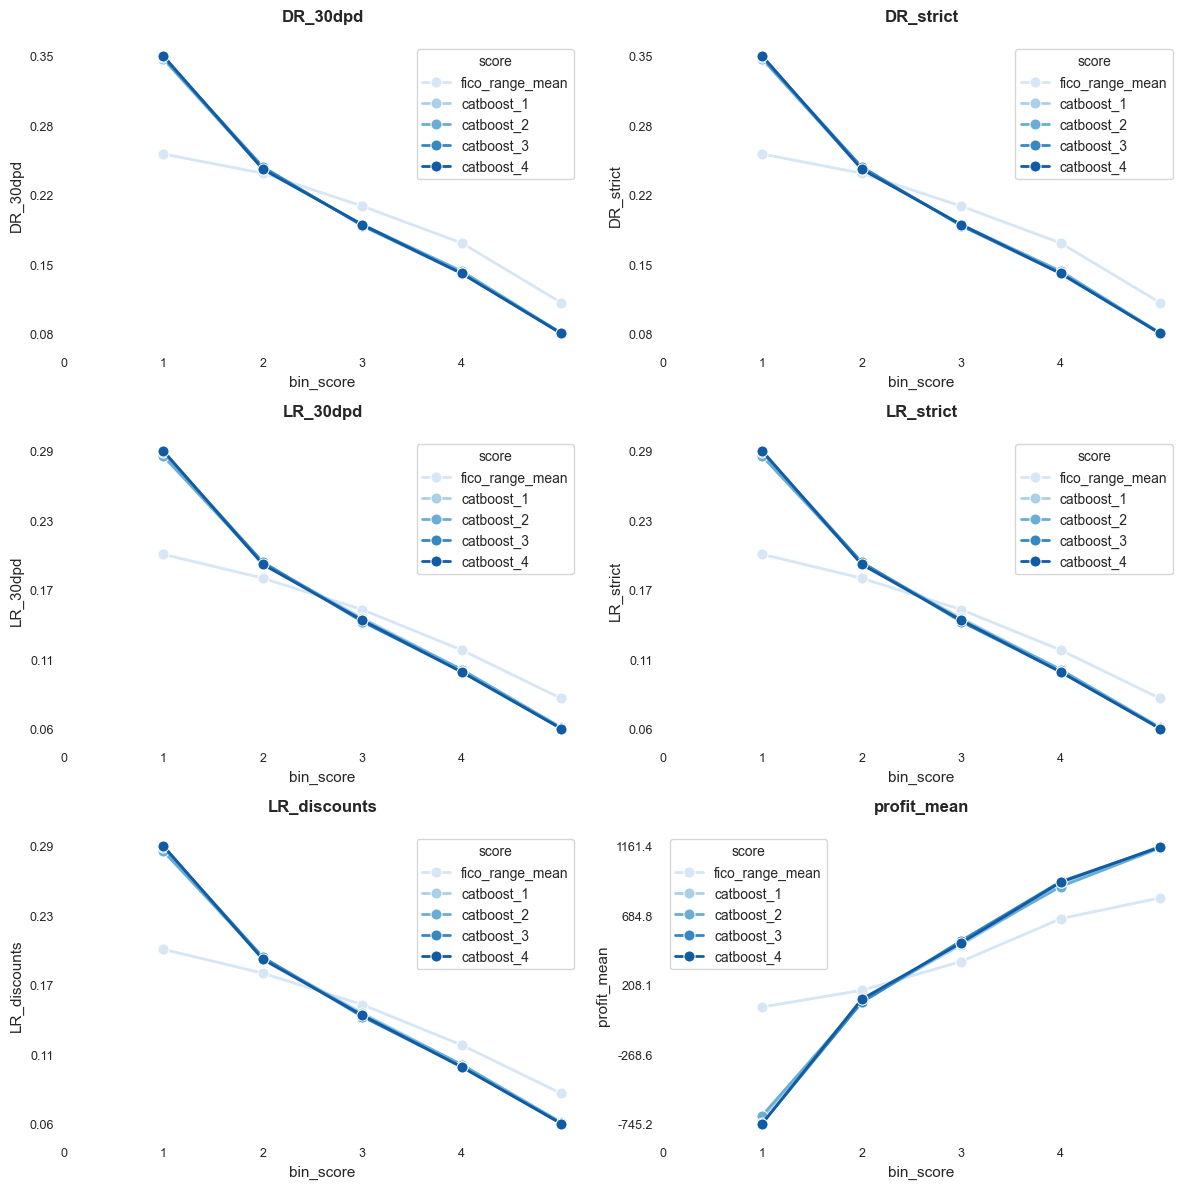

✅ Grid de 6 gráficas mostrado (3 filas x 2 columnas)


In [12]:
# Ejemplo de uso de la función grid (muestra todas las gráficas en el notebook)
# Preparar el DataFrame si aún no está preparado
df_plot_grid = gb_mature_at_default#.reset_index()

# Identificar la columna de bin (usar la misma lógica que antes)
bin_columns_grid = [col for col in df_plot_grid.columns if col.endswith('_bin')]
if len(bin_columns_grid) > 0:
    x_col_grid = bin_columns_grid[0]
elif 'mature_at_default' in df_plot_grid.columns:
    possible_bin_cols = [col for col in df_plot_grid.columns if 'bin' in col.lower() or 'Bin' in col]
    if len(possible_bin_cols) > 0:
        x_col_grid = possible_bin_cols[0]
    elif isinstance(gb_mature_at_default.index, pd.MultiIndex):
        x_col_grid = gb_mature_at_default.index.names[1] if len(gb_mature_at_default.index.names) > 1 else None
    else:
        x_col_grid = None
else:
    x_col_grid = None

if x_col_grid:
    # Crear el grid de gráficas
    plot_metrics_by_score_grid(
        df=df_plot_grid,
        metrics_list=metrics_to_plot,
        x_column=x_col_grid,
        score_column='score',
        figsize_per_plot=(6, 4)  # Tamaño de cada subplot
    )
else:
    print("⚠️  No se pudo identificar la columna de bin para el grid")


### Interpretation

#### Some assumptions

- Until now the score that is used to make risk-decisions is the FICO Score. As a proxxy, I created the FICO Mean as result of the Fico range low and high received at the evaluation.

- I'm considering that, eventough one of the new experiments will be the new *champion*, during the loan application, we'll still be consuming that score as a feature. Since the correlation wasn't that high, I let it enter to the training as a feature of the model

- In this plots I'm comparing how each model (score) acumulate Defult Rate, Loss Rate and Profit by bin (using 5 bins in this example).

- The riskier the client, the lower the score.

- The lower the score, the lower the corresponding bin.

- A way to interpretate that a model-X is better than a model-Y because the model-X acumulate more LR and DR at the lowest bins, and acumulate less of those metrics at the best bins

- In that way, a model-X is better than a model-Y because the model-X acumulate less profit average per loan at the lowest bins, and acumulate more of it at the best bins

- The best practice to use this plots is with a Out Of Time Control Group dataset in order to eliminate the bias that comes from the actual productive model's decisions regarding to accept or reject a loan. Since we don't have clarity of which clients are control group or not, we'll use all disbursment loans from the OOT sample.

### Results
- From this plots we can see that all new experiments are better than the champion (FICO) because they acumulate a lot more the LR and DR at the worst bin and those metrics are sorted with the score, meaning that as the score (bin) increases, the LR and DR decreases. Which is actualli what we want: the model is capable to differenciate very well the default customers from the ones that do pay.

- The profit as the inverse behaviour, meaning that all the experiments acumulate less profit at the worst bins and acumulate more at the best levels of score, which means more loans to disbursed more efficient and PTU for everybody ;) (joking XD XD XD)

- Among the experiments, all seems good, but the `catboost_4` looks a little better at all metrics... That one used:
    - The largest window for training, from November 2013 to July 2015
    - OOT from Aug 2015 to February 2016
    - Without `use_class_weights`, meaning this experiment does not balance the classes of target variable

- Let's check the results we'd have per acceptence rate



## Acceptance vs metrics

In [55]:
score_columns=['fico_range_mean']+experiments_01

mature_at = 'mature_at_default'
key_cols = ['score','acceptance_rate','cutoff','risk_decision']
performance_cols = ['DR_30dpd','DR_strict','LR_30dpd','LR_strict','LR_discounts','profit_mean']

dict_to_agg_strict = {
        'id':'count',
        #'installment':'mean',
        #'int_rate':'mean',
        #'term_int':'mean',
        'is_paid_prior_30dpd':'mean',
        'is_paid_strict':'mean',
        'loan_amnt':'sum',
        'pre_LR__30dpd':'sum',
        'pre_LR__strict':'sum',
        'pre_LR__discounts':'sum',
        'profit':'sum',
        'score_mean':'mean'
        }
        

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # Suprimir SettingWithCopyWarning

# Crear copia para evitar warnings
universe_mature_loans = scores_with_bins[scores_with_bins[mature_at]==True].copy()
gb_all_accepted = pd.DataFrame()
gb_all_rejected = pd.DataFrame()


for scoretmp in score_columns:
    if scoretmp not in ['fico_range_mean','catboost_4']:
        continue
    for acctmp in [x/100 for x in range(10,105,5)]:
        print(f"{acctmp} - {scoretmp}")
        cutoff = universe_mature_loans[scoretmp].quantile(1-acctmp)
        universe_mature_loans[f"I_cutoff_{int(acctmp*100)}acceptance__{scoretmp}"] = cutoff
        universe_mature_loans[f"I_within_{int(acctmp*100)}acceptance__{scoretmp}"] = (universe_mature_loans[
            scoretmp
            ]>=cutoff).astype(int)
        accepted_loans_tmp = universe_mature_loans[universe_mature_loans[scoretmp]>=cutoff]
        rejected_loans_tmp = universe_mature_loans[universe_mature_loans[scoretmp]<cutoff]


        gb_tmp_accepted = accepted_loans_tmp.rename(columns={scoretmp:'score_mean'}).agg(
                dict_to_agg_strict
            ).to_frame().transpose().assign(
                DR_30dpd = lambda x: 1-x['is_paid_prior_30dpd'],
                DR_strict = lambda x: 1-x['is_paid_strict'],
                LR_30dpd = lambda x: x['pre_LR__30dpd']/x['loan_amnt'],
                LR_strict = lambda x: x['pre_LR__strict']/x['loan_amnt'],
                LR_discounts = lambda x: x['pre_LR__discounts']/x['loan_amnt'],
                profit_mean = lambda x: x['profit']/x['id'],
                score = scoretmp,
                acceptance_rate = acctmp*100,
                cutoff = cutoff,
                risk_decision = 'accepted'
            ).rename(
                columns={'id':'nb_loans'}
            )
        gb_tmp_accepted = gb_tmp_accepted[
            key_cols + performance_cols+ [
                x for x in gb_tmp_accepted.columns if x not in key_cols+performance_cols
                ]
        ]

        gb_tmp_rejected = rejected_loans_tmp.rename(columns={scoretmp:'score_mean'}).agg(
                dict_to_agg_strict
            ).to_frame().transpose().assign(
                DR_30dpd = lambda x: 1-x['is_paid_prior_30dpd'],
                DR_strict = lambda x: 1-x['is_paid_strict'],
                LR_30dpd = lambda x: x['pre_LR__30dpd']/x['loan_amnt'],
                LR_strict = lambda x: x['pre_LR__strict']/x['loan_amnt'],
                LR_discounts = lambda x: x['pre_LR__discounts']/x['loan_amnt'],
                profit_mean = lambda x: x['profit']/x['id'],
                score = scoretmp,
                acceptance_rate = acctmp*100,
                cutoff = cutoff,
                risk_decision = 'rejected'
            ).rename(
                columns={'id':'nb_loans'}
            )
        
        gb_all_accepted = pd.concat([gb_all_accepted,gb_tmp_accepted],axis=0)
        gb_all_rejected = pd.concat([gb_all_rejected,gb_tmp_rejected],axis=0)

gb_all_accepted = gb_all_accepted[
    key_cols + performance_cols+ [
        x for x in gb_all_accepted.columns if x not in key_cols+performance_cols
        ]
]

gb_all_rejected = gb_all_rejected[
    key_cols + performance_cols+ [
        x for x in gb_all_rejected.columns if x not in key_cols+performance_cols
        ]
]

display(gb_all_accepted)
display(gb_all_rejected)

0.1 - fico_range_mean
0.15 - fico_range_mean
0.2 - fico_range_mean
0.25 - fico_range_mean
0.3 - fico_range_mean
0.35 - fico_range_mean
0.4 - fico_range_mean
0.45 - fico_range_mean
0.5 - fico_range_mean
0.55 - fico_range_mean
0.6 - fico_range_mean
0.65 - fico_range_mean
0.7 - fico_range_mean
0.75 - fico_range_mean
0.8 - fico_range_mean
0.85 - fico_range_mean
0.9 - fico_range_mean
0.95 - fico_range_mean
1.0 - fico_range_mean
0.1 - catboost_4
0.15 - catboost_4
0.2 - catboost_4
0.25 - catboost_4
0.3 - catboost_4
0.35 - catboost_4
0.4 - catboost_4
0.45 - catboost_4
0.5 - catboost_4
0.55 - catboost_4
0.6 - catboost_4
0.65 - catboost_4
0.7 - catboost_4
0.75 - catboost_4
0.8 - catboost_4
0.85 - catboost_4
0.9 - catboost_4
0.95 - catboost_4
1.0 - catboost_4


,score,acceptance_rate,cutoff,risk_decision,DR_30dpd,DR_strict,LR_30dpd,LR_strict,LR_discounts,profit_mean,nb_loans,is_paid_prior_30dpd,is_paid_strict,loan_amnt,pre_LR__30dpd,pre_LR__strict,pre_LR__discounts,profit,score_mean
0,fico_range_mean,10.0,737.000000,accepted,0.089951,0.089951,0.068638,0.068638,0.068638,830.030215,26559.0,0.910049,0.910049,4.282960e+08,2.939747e+07,2.939747e+07,2.939747e+07,2.204477e+07,762.956079
0,fico_range_mean,15.0,727.000000,accepted,0.101326,0.101326,0.077675,0.077675,0.077675,808.423136,37256.0,0.898674,0.898674,6.053212e+08,4.701830e+07,4.701830e+07,4.701830e+07,3.011861e+07,753.293953
0,fico_range_mean,20.0,717.000000,accepted,0.114560,0.114560,0.085858,0.085858,0.085858,800.156414,53291.0,0.885440,0.885440,8.678742e+08,7.451400e+07,7.451400e+07,7.451400e+07,4.264114e+07,743.056886
0,fico_range_mean,25.0,712.000000,accepted,0.121981,0.121981,0.090989,0.090989,0.090989,778.421838,63346.0,0.878019,0.878019,1.029480e+09,9.367180e+07,9.367180e+07,9.367180e+07,4.930991e+07,738.127182
0,fico_range_mean,30.0,707.000000,accepted,0.129007,0.129007,0.095761,0.095761,0.095761,761.034133,74709.0,0.870993,0.870993,1.209383e+09,1.158119e+08,1.158119e+08,1.158119e+08,5.685610e+07,733.392838
0,fico_range_mean,35.0,702.000000,accepted,0.136637,0.136637,0.101404,0.101404,0.101404,734.315791,87275.0,0.863363,0.863363,1.406854e+09,1.426607e+08,1.426607e+08,1.426607e+08,6.408741e+07,728.872844
0,fico_range_mean,40.0,697.000000,accepted,0.144388,0.144388,0.107231,0.107231,0.107231,698.746113,100957.0,0.855612,0.855612,1.617563e+09,1.734534e+08,1.734534e+08,1.734534e+08,7.054331e+07,724.553340
0,fico_range_mean,45.0,692.000000,accepted,0.152275,0.152275,0.113539,0.113539,0.113539,651.691102,116342.0,0.847725,0.847725,1.851749e+09,2.102456e+08,2.102456e+08,2.102456e+08,7.581905e+07,720.248504
0,fico_range_mean,50.0,687.000000,accepted,0.159416,0.159416,0.119313,0.119313,0.119313,609.819380,132151.0,0.840584,0.840584,2.083562e+09,2.485966e+08,2.485966e+08,2.485966e+08,8.058824e+07,716.271042
0,fico_range_mean,55.0,687.000000,accepted,0.159416,0.159416,0.119313,0.119313,0.119313,609.819380,132151.0,0.840584,0.840584,2.083562e+09,2.485966e+08,2.485966e+08,2.485966e+08,8.058824e+07,716.271042


,score,acceptance_rate,cutoff,risk_decision,DR_30dpd,DR_strict,LR_30dpd,LR_strict,LR_discounts,profit_mean,nb_loans,is_paid_prior_30dpd,is_paid_strict,loan_amnt,pre_LR__30dpd,pre_LR__strict,pre_LR__discounts,profit,score_mean
0,fico_range_mean,10.0,737.000000,rejected,0.212268,0.212268,0.161107,0.161107,0.161107,329.044524,208185.0,0.787732,0.787732,3.036177e+09,4.891484e+08,4.891484e+08,4.891484e+08,6.850213e+07,688.220333
0,fico_range_mean,15.0,727.000000,rejected,0.216747,0.216747,0.164919,0.164919,0.164919,305.984638,197488.0,0.783253,0.783253,2.859152e+09,4.715276e+08,4.715276e+08,4.715276e+08,6.042829e+07,685.995002
0,fico_range_mean,20.0,717.000000,rejected,0.223061,0.223061,0.171005,0.171005,0.171005,264.012009,181453.0,0.776939,0.776939,2.596599e+09,4.440319e+08,4.440319e+08,4.440319e+08,4.790577e+07,683.054323
0,fico_range_mean,25.0,712.000000,rejected,0.226683,0.226683,0.174487,0.174487,0.174487,240.592054,171398.0,0.773317,0.773317,2.434993e+09,4.248741e+08,4.248741e+08,4.248741e+08,4.123700e+07,681.356235
0,fico_range_mean,30.0,707.000000,rejected,0.230837,0.230837,0.178589,0.178589,0.178589,210.521496,160035.0,0.769163,0.769163,2.255090e+09,4.027340e+08,4.027340e+08,4.027340e+08,3.369081e+07,679.535445
0,fico_range_mean,35.0,702.000000,rejected,0.234999,0.234999,0.182680,0.182680,0.182680,179.424123,147469.0,0.765001,0.765001,2.057619e+09,3.758851e+08,3.758851e+08,3.758851e+08,2.645950e+07,677.621215
0,fico_range_mean,40.0,697.000000,rejected,0.239209,0.239209,0.186849,0.186849,0.186849,149.518229,133787.0,0.760791,0.760791,1.846911e+09,3.450925e+08,3.450925e+08,3.450925e+08,2.000360e+07,675.639404
0,fico_range_mean,45.0,692.000000,rejected,0.243780,0.243780,0.191167,0.191167,0.191167,124.388612,118402.0,0.756220,0.756220,1.612724e+09,3.083003e+08,3.083003e+08,3.083003e+08,1.472786e+07,673.513530
0,fico_range_mean,50.0,687.000000,rejected,0.248682,0.248682,0.195486,0.195486,0.195486,97.069642,102593.0,0.751318,0.751318,1.380911e+09,2.699492e+08,2.699492e+08,2.699492e+08,9.958666e+06,671.435342
0,fico_range_mean,55.0,687.000000,rejected,0.248682,0.248682,0.195486,0.195486,0.195486,97.069642,102593.0,0.751318,0.751318,1.380911e+09,2.699492e+08,2.699492e+08,2.699492e+08,9.958666e+06,671.435342


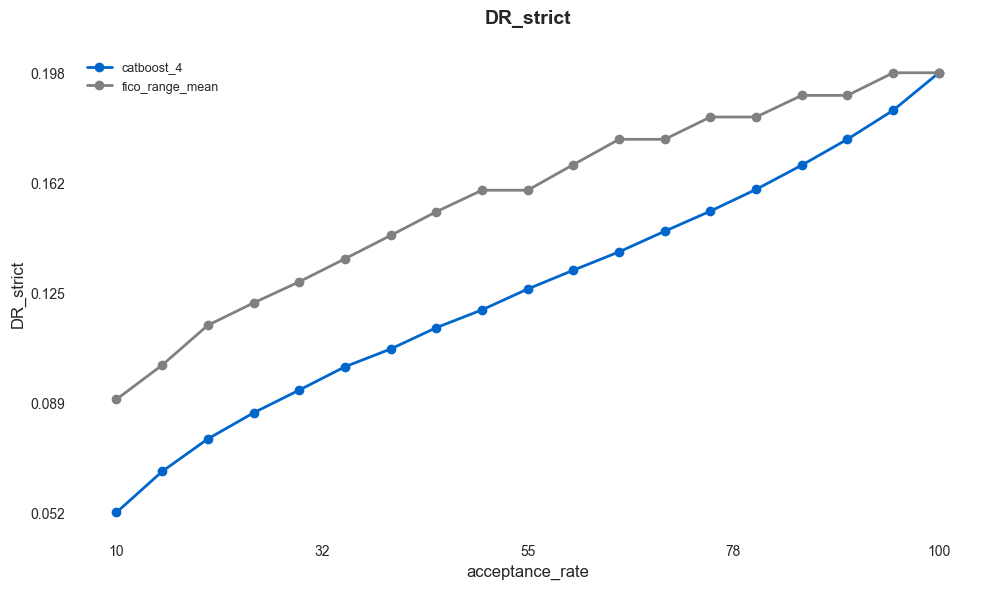

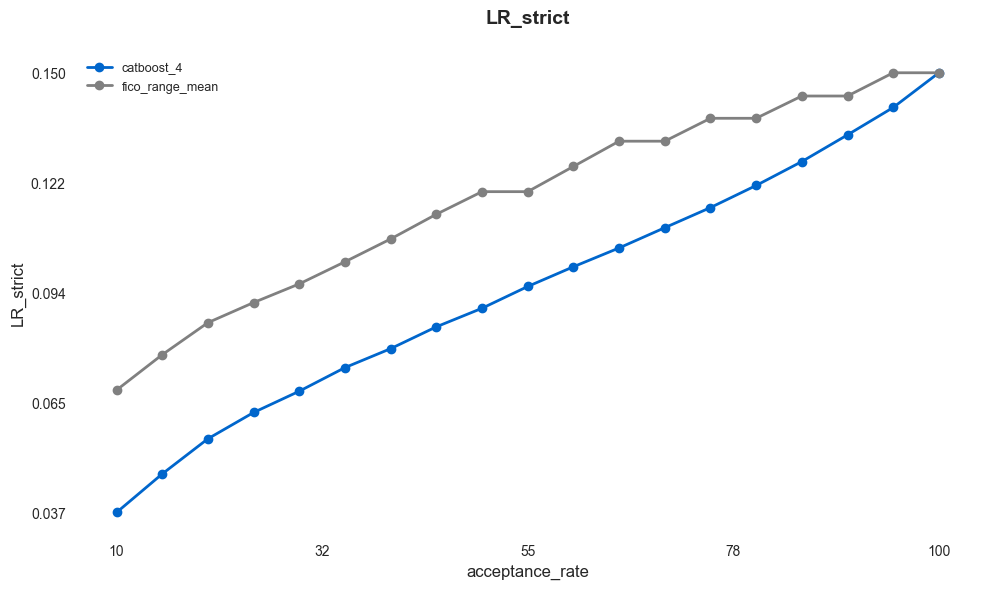

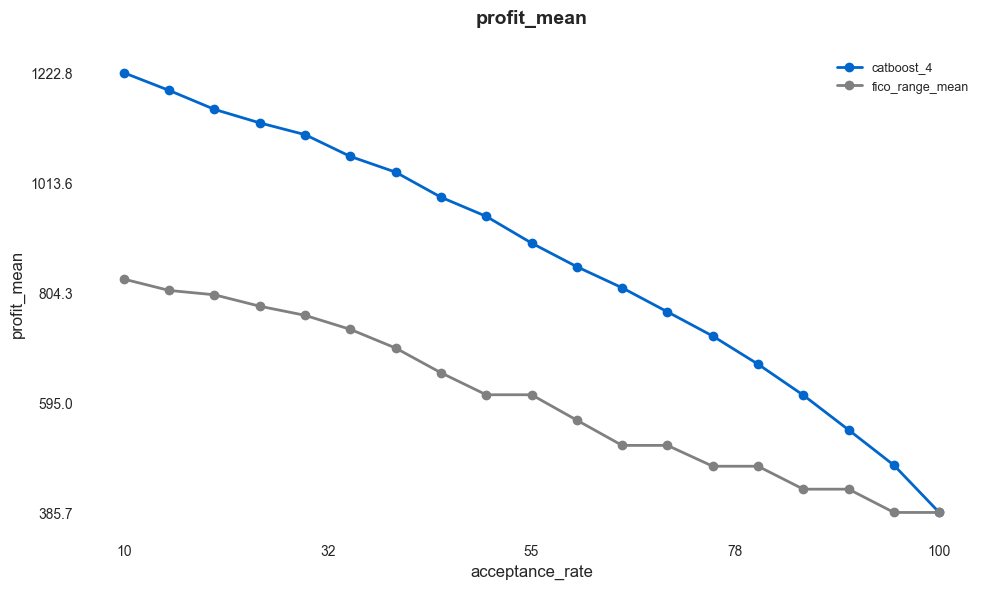

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plot_acceptance_rate_metrics(df, metrics_list, x_column='acceptance_rate', 
                                 score_column='score', save_path=None, 
                                 figsize=(10, 6), n_ticks=5):
    """
    Crea lineplots de métricas vs acceptance_rate con hue por score.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame con los datos (ej: gb_all_accepted)
    metrics_list : list
        Lista de nombres de columnas de métricas a graficar
    x_column : str
        Nombre de la columna para el eje X (default: 'acceptance_rate')
    score_column : str
        Nombre de la columna que contiene los nombres de los scores (default: 'score')
    save_path : str, optional
        Directorio donde guardar las imágenes. Si None, solo muestra las gráficas
    figsize : tuple
        Tamaño de las figuras (default: (10, 6))
    n_ticks : int
        Número aproximado de ticks a mostrar en los ejes (default: 5)
    """
    # Configurar estilo
    sns.set_style("white")
    
    # Definir colores personalizados
    # 'fico_range_mean' en gris, otros scores en tonos de azul
    unique_scores = sorted(df[score_column].unique())
    color_map = {}
    
    # Color gris para fico_range_mean
    if 'fico_range_mean' in unique_scores:
        color_map['fico_range_mean'] = '#808080'  # Gris
    
    # Colores azules para los demás scores
    blue_scores = [s for s in unique_scores if s != 'fico_range_mean']
    if len(blue_scores) > 0:
        # Crear paleta de azules oscuros (usando solo los tonos más oscuros)
        # DarkBlue base: #00008B, luego variaciones más oscuras
        dark_blues = [
            #'#00008B',  # DarkBlue
            #'#0000CD',  # MediumBlue
           # '#191970',  # MidnightBlue
           # '#000080',  # Navy
           # '#1E90FF',  # DodgerBlue
            '#0066CC',  # Blue
            '#003366',  # Dark blue
            '#004080',  # Darker blue
        ]
        
        # Asignar colores azules oscuros
        for i, score in enumerate(blue_scores):
            if i < len(dark_blues):
                color_map[score] = dark_blues[i]
            else:
                # Si hay más scores que colores, usar darkblue como default
                color_map[score] = '#00008B'  # DarkBlue
    
    # Crear una gráfica por cada métrica
    for metric in metrics_list:
        if metric not in df.columns:
            print(f"⚠️  Métrica '{metric}' no encontrada en el DataFrame. Saltando...")
            continue
        
        # Crear figura
        fig, ax = plt.subplots(figsize=figsize, facecolor='white')
        
        # Crear lineplot con colores personalizados
        for score in unique_scores:
            df_score = df[df[score_column] == score].sort_values(x_column)
            ax.plot(
                df_score[x_column],
                df_score[metric],
                marker='o',
                markersize=6,
                linewidth=2,
                label=score,
                color=color_map.get(score, '#00008B')  # DarkBlue como default
            )
        
        # Aplicar estilo: sin spines, sin grids
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(False)
        
        # Configurar ticks del eje X (mínimo, máximo y algunos intermedios)
        x_values = df[x_column].unique()
        x_min, x_max = x_values.min(), x_values.max()
        # Asegurar que mínimo y máximo estén incluidos
        x_ticks = np.linspace(x_min, x_max, n_ticks)
        x_ticks = np.unique(np.concatenate([[x_min], x_ticks, [x_max]]))  # Incluir min y max
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'{val:.0f}' for val in x_ticks], fontsize=10)
        
        # Configurar ticks del eje Y (mínimo, máximo y algunos intermedios)
        y_values = df[metric].dropna()
        if len(y_values) > 0:
            y_min, y_max = y_values.min(), y_values.max()
            # Asegurar que mínimo y máximo estén incluidos
            y_ticks = np.linspace(y_min, y_max, n_ticks)
            y_ticks = np.unique(np.concatenate([[y_min], y_ticks, [y_max]]))  # Incluir min y max
            ax.set_yticks(y_ticks)
            # Formatear según el rango de valores
            if abs(y_max) < 1:
                ax.set_yticklabels([f'{val:.3f}' for val in y_ticks], fontsize=10)
            elif abs(y_max) < 10:
                ax.set_yticklabels([f'{val:.2f}' for val in y_ticks], fontsize=10)
            else:
                ax.set_yticklabels([f'{val:.1f}' for val in y_ticks], fontsize=10)
        
        # Labels de ejes
        ax.set_xlabel(x_column, fontsize=12, fontweight='normal')
        ax.set_ylabel(metric, fontsize=12, fontweight='normal')
        
        # Título
        ax.set_title(metric, fontsize=14, fontweight='bold', pad=20)
        
        # Leyenda
        ax.legend(loc='best', fontsize=9, frameon=False)
        
        # Ajustar layout
        plt.tight_layout()
        
        # Guardar o mostrar
        if save_path:
            import os
            os.makedirs(save_path, exist_ok=True)
            filename = os.path.join(save_path, f'{metric}_vs_{x_column}.png')
            plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"✅ Gráfica guardada: {filename}")
            plt.close()
        else:
            plt.show()
    
    if save_path:
        print(f"\n✅ Todas las gráficas guardadas en: {save_path}")

# Definir métricas a graficar
metrics_to_plot = ['DR_strict', 'LR_strict', 'profit_mean']

# Crear las gráficas
plot_acceptance_rate_metrics(
    df=gb_all_accepted,
    metrics_list=metrics_to_plot,
    x_column='acceptance_rate',
    score_column='score',
    save_path = None, #'../plots/acceptance_rate_analysis_catboost04', 
    figsize=(10, 6),
    n_ticks=5
)


### Comments

- As mentioned with the previous visualization, the correct way to use these ones is within a Out Of Time Control-Group dataset. In this case, we're still using all disbursed loans from OOT sample.

- This plots show the bussines-metrics we would get by each model per each cuttoff point. That gives the visibility of the complete scores' range and how it reflects on losses, default and profit. 

- A model-X is better than model-Y is it gets less default or loss by the same Z-acceptance level, because that means model-X is capable of allocate better to the best Z% of the custumer that ask for a loan to us.

- We can see how for all the metrics, our challenger `catboost_4` identify better the "good" customers from the "bad" ones across all the range of acceptance we could get

- So, at whichever level of acceptance that we should meet from the KPIs, the new model is going to deliver lower Default Rate, lower Loss Rate and higher profit per loan

- Let's take a look to the features..

## Shaps

In [13]:
import shap
import matplotlib.pyplot as plt

def calculate_shap_summary_plots(experiments_list, resultados_comparativos, df_data, 
                                 sample_size=1000, save_path=None, show_plots=True):
    """
    Calcula SHAP summary plots para cada experimento en la lista.
    
    Parameters:
    -----------
    experiments_list : list
        Lista de nombres de scores (ej: ['catboost_1', 'catboost_2', ...])
    resultados_comparativos : dict
        Diccionario con 'full_results' que contiene los resultados de los experimentos
    df_data : pandas.DataFrame
        DataFrame con los datos para calcular SHAP (debe tener las features usadas en el entrenamiento)
    sample_size : int
        Número de muestras a usar para calcular SHAP (default: 1000). 
        Si None, usa todos los datos (puede ser lento)
    save_path : str, optional
        Directorio donde guardar los plots. Si None, no guarda
    show_plots : bool
        Si True, muestra los plots en el notebook (default: True)
    
    Returns:
    --------
    dict
        Diccionario con SHAP explainers y values para cada experimento
    """
    try:
        import shap
    except ImportError:
        raise ImportError("SHAP no está instalado. Instala con: pip install shap")
    
    full_results = resultados_comparativos.get('full_results', [])
    
    if len(full_results) == 0:
        print("❌ No hay resultados completos disponibles en resultados_comparativos")
        return {}
    
    shap_results = {}
    
    print(f"📊 Calculando SHAP summary plots para {len(experiments_list)} experimentos...")
    print("="*70)
    
    for score_name in experiments_list:
        # Extraer número de experimento del nombre (ej: 'catboost_1' -> 1)
        try:
            exp_num = int(score_name.split('_')[-1])
        except:
            print(f"⚠️  No se pudo extraer número de experimento de '{score_name}'. Saltando...")
            continue
        
        # Buscar el experimento correspondiente (los índices empiezan en 0, pero los nombres en 1)
        if exp_num < 1 or exp_num > len(full_results):
            print(f"⚠️  Experimento {exp_num} no encontrado. Saltando '{score_name}'...")
            continue
        
        res = full_results[exp_num - 1]  # -1 porque los índices empiezan en 0
        
        if res is None:
            print(f"⚠️  Experimento {exp_num} tuvo un error. Saltando '{score_name}'...")
            continue
        
        model = res.get('model')
        if model is None:
            print(f"⚠️  Modelo no encontrado para '{score_name}'. Saltando...")
            continue
        
        print(f"\n🔍 Procesando: {score_name} (Experimento {exp_num})")
        
        # Obtener información del experimento
        info = res.get('experiment_info', {})
        algorithm = info.get('algorithm', 'unknown')
        encoder = res.get('encoder')
        numeric_features = res.get('numeric_features', [])
        categorical_features = res.get('categorical_features', [])
        features_list = numeric_features + categorical_features
        encoder_type = info.get('encoder_type', 'native')
        
        # Preparar datos para SHAP
        print(f"   - Algoritmo: {algorithm}")
        print(f"   - Features: {len(features_list)} ({len(numeric_features)} numéricas, {len(categorical_features)} categóricas)")
        
        # Verificar que las features existan en df_data
        available_features = [f for f in features_list if f in df_data.columns]
        missing_features = set(features_list) - set(available_features)
        
        if missing_features:
            print(f"   ⚠️  Features faltantes: {missing_features}")
        
        if len(available_features) == 0:
            print(f"   ❌ No hay features disponibles. Saltando...")
            continue
        
        # Preparar datos usando la misma función que para scoring
        X_shap = prepare_features_for_scoring(
            df_pop=df_data,
            features_list=available_features,
            categorical_features=categorical_features,
            algorithm=algorithm,
            encoder=encoder,
            encoder_type=encoder_type if isinstance(encoder_type, str) else 'native'
        )
        
        # Muestrear datos si es necesario (SHAP puede ser lento con muchos datos)
        if sample_size and len(X_shap) > sample_size:
            X_shap_sample = X_shap.sample(n=sample_size, random_state=42)
            print(f"   - Usando muestra de {sample_size} registros de {len(X_shap)} totales")
        else:
            X_shap_sample = X_shap
            print(f"   - Usando todos los {len(X_shap)} registros")
        
        try:
            # Crear explainer según el algoritmo
            if algorithm.lower() == 'catboost':
                explainer = shap.TreeExplainer(model)
            elif algorithm.lower() in ['xgboost', 'lgbm', 'lightgbm']:
                explainer = shap.TreeExplainer(model)
            else:
                # Para otros algoritmos, usar KernelExplainer (más lento)
                print(f"   ⚠️  Algoritmo '{algorithm}' no soportado directamente. Usando KernelExplainer (puede ser lento)...")
                # Usar una muestra más pequeña para KernelExplainer
                if len(X_shap_sample) > 100:
                    X_shap_sample = X_shap_sample.sample(n=100, random_state=42)
                explainer = shap.KernelExplainer(model.predict_proba, X_shap_sample.head(50))
            
            # Calcular SHAP values
            print(f"   - Calculando SHAP values...")
            shap_values = explainer.shap_values(X_shap_sample)
            
            # Para modelos binarios, shap_values puede ser una lista [values_class_0, values_class_1]
            # Usamos la clase 1 (positiva) que es la que nos interesa
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Clase positiva
            
            # Crear summary plot
            print(f"   - Generando summary plot...")
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_shap_sample, show=False, plot_size=(10, 8))
            plt.title(f'SHAP Summary Plot - {score_name}', fontsize=14, fontweight='bold', pad=20)
            
            if save_path:
                import os
                os.makedirs(save_path, exist_ok=True)
                filename = os.path.join(save_path, f'shap_summary_{score_name}.png')
                plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
                print(f"   ✅ Plot guardado: {filename}")
            
            if show_plots:
                plt.show()
            else:
                plt.close()
            
            # Guardar resultados
            shap_results[score_name] = {
                'explainer': explainer,
                'shap_values': shap_values,
                'X_sample': X_shap_sample,
                'features': available_features
            }
            
            print(f"   ✅ Completado: {score_name}")
            
        except Exception as e:
            print(f"   ❌ Error calculando SHAP para '{score_name}': {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    print("\n" + "="*70)
    print(f"✅ Proceso completado. SHAP calculado para {len(shap_results)} experimentos")
    
    return shap_results

# Ejemplo de uso:
# shap_results = calculate_shap_summary_plots(
#     experiments_list=experiments_01,
#     resultados_comparativos=resultados_comparativos,
#     df_data=df_pop,  # DataFrame con los datos para calcular SHAP
#     sample_size=1000,  # Usar 1000 muestras (ajustar según necesidad)
#     save_path='./plots/shap_summary',  # Guardar plots
#     show_plots=True  # Mostrar en notebook
# )


In [14]:
def calculate_shap_by_category_all_experiments(experiments_list, resultados_comparativos, df_data,
                                               sample_size=None, save_path=None):
    """
    Calcula SHAP por categoría para todas las features categóricas de todos los experimentos.
    
    Parameters:
    -----------
    experiments_list : list
        Lista de nombres de scores (ej: ['catboost_1', 'catboost_2', ...])
    resultados_comparativos : dict
        Diccionario con 'full_results' que contiene los resultados de los experimentos
    df_data : pandas.DataFrame
        DataFrame con los datos para calcular SHAP (debe tener las features usadas en el entrenamiento)
    sample_size : int, optional
        Número de muestras a usar para calcular SHAP. Si None, usa todos los datos
    save_path : str, optional
        Directorio donde guardar los resultados en CSV. Si None, no guarda
    
    Returns:
    --------
    dict
        Diccionario con estructura: {experiment_name: {feature_name: shap_by_category_series}}
    """
    try:
        import shap
    except ImportError:
        raise ImportError("SHAP no está instalado. Instala con: pip install shap")
    
    full_results = resultados_comparativos.get('full_results', [])
    
    if len(full_results) == 0:
        print("❌ No hay resultados completos disponibles en resultados_comparativos")
        return {}
    
    all_shap_by_category = {}
    
    print(f"📊 Calculando SHAP por categoría para {len(experiments_list)} experimentos...")
    print("="*70)
    
    for score_name in experiments_list:
        # Extraer número de experimento del nombre (ej: 'catboost_1' -> 1)
        try:
            exp_num = int(score_name.split('_')[-1])
        except:
            print(f"⚠️  No se pudo extraer número de experimento de '{score_name}'. Saltando...")
            continue
        
        # Buscar el experimento correspondiente
        if exp_num < 1 or exp_num > len(full_results):
            print(f"⚠️  Experimento {exp_num} no encontrado. Saltando '{score_name}'...")
            continue
        
        res = full_results[exp_num - 1]
        
        if res is None:
            print(f"⚠️  Experimento {exp_num} tuvo un error. Saltando '{score_name}'...")
            continue
        
        model = res.get('model')
        if model is None:
            print(f"⚠️  Modelo no encontrado para '{score_name}'. Saltando...")
            continue
        
        print(f"\n🔍 Procesando: {score_name} (Experimento {exp_num})")
        
        # Obtener información del experimento
        info = res.get('experiment_info', {})
        algorithm = info.get('algorithm', 'unknown')
        encoder = res.get('encoder')
        numeric_features = res.get('numeric_features', [])
        categorical_features = res.get('categorical_features', [])
        features_list = numeric_features + categorical_features
        encoder_type = info.get('encoder_type', 'native')
        
        if len(categorical_features) == 0:
            print(f"   ⚠️  No hay features categóricas en este experimento. Saltando...")
            continue
        
        print(f"   - Algoritmo: {algorithm}")
        print(f"   - Features categóricas: {len(categorical_features)}")
        
        # Verificar que las features existan en df_data
        available_features = [f for f in features_list if f in df_data.columns]
        available_categorical = [f for f in categorical_features if f in df_data.columns]
        missing_features = set(features_list) - set(available_features)
        
        if missing_features:
            print(f"   ⚠️  Features faltantes: {missing_features}")
        
        if len(available_categorical) == 0:
            print(f"   ⚠️  No hay features categóricas disponibles. Saltando...")
            continue
        
        # Preparar datos usando la misma función que para scoring
        X_shap = prepare_features_for_scoring(
            df_pop=df_data,
            features_list=available_features,
            categorical_features=categorical_features,
            algorithm=algorithm,
            encoder=encoder,
            encoder_type=encoder_type if isinstance(encoder_type, str) else 'native'
        )
        
        # Muestrear datos si es necesario
        if sample_size and len(X_shap) > sample_size:
            X_shap_sample = X_shap.sample(n=sample_size, random_state=42)
            print(f"   - Usando muestra de {sample_size} registros de {len(X_shap)} totales")
        else:
            X_shap_sample = X_shap
            print(f"   - Usando todos los {len(X_shap)} registros")
        
        try:
            # Crear explainer según el algoritmo
            if algorithm.lower() in ['catboost', 'xgboost', 'lgbm', 'lightgbm']:
                explainer = shap.TreeExplainer(model)
            else:
                print(f"   ⚠️  Algoritmo '{algorithm}' no soportado directamente. Saltando...")
                continue
            
            # Calcular SHAP values
            print(f"   - Calculando SHAP values...")
            shap_values = explainer.shap_values(X_shap_sample)
            
            # Para modelos binarios, shap_values puede ser una lista [values_class_0, values_class_1]
            # Usamos la clase 1 (positiva) que es la que nos interesa
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Clase positiva
            
            # Convertir a DataFrame si no lo es
            if not isinstance(shap_values, pd.DataFrame):
                shap_values = pd.DataFrame(shap_values, columns=X_shap_sample.columns, index=X_shap_sample.index)
            
            # Para cada feature categórica, calcular SHAP por categoría
            shap_by_category_exp = {}
            
            # Necesitamos los valores originales de las categorías (antes del encoding)
            # Si hay encoder, necesitamos mapear de vuelta o usar los datos originales
            X_original = df_data[available_categorical].copy()
            
            # Asegurar que el índice coincida
            if len(X_original) != len(X_shap_sample):
                # Si se muestreó, necesitamos alinear
                X_original = X_original.loc[X_shap_sample.index]
            
            for feature_name in available_categorical:
                if feature_name not in X_shap_sample.columns:
                    # La feature fue codificada, necesitamos encontrar su columna codificada
                    # Para WOE encoder, el nombre puede ser el mismo
                    # Para LabelEncoder, también es el mismo
                    if feature_name not in shap_values.columns:
                        print(f"   ⚠️  Feature '{feature_name}' no encontrada en SHAP values. Saltando...")
                        continue
                
                feature_idx = X_shap_sample.columns.get_loc(feature_name)
                
                # Crear DataFrame con categorías originales y SHAP values
                shap_df = pd.DataFrame({
                    "category": X_original[feature_name].values,
                    "shap_value": shap_values.iloc[:, feature_idx].values
                })
                
                # Calcular SHAP promedio por categoría
                shap_by_category = (
                    shap_df
                    .groupby("category")["shap_value"]
                    .mean()
                    .sort_values()
                )
                
                shap_by_category_exp[feature_name] = shap_by_category
                
                print(f"   ✅ {feature_name}: {len(shap_by_category)} categorías")
            
            all_shap_by_category[score_name] = shap_by_category_exp
            
            print(f"   ✅ Completado: {score_name} ({len(shap_by_category_exp)} features categóricas)")
            
        except Exception as e:
            print(f"   ❌ Error calculando SHAP para '{score_name}': {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    print("\n" + "="*70)
    print(f"✅ Proceso completado. SHAP por categoría calculado para {len(all_shap_by_category)} experimentos")
    
    # Guardar resultados si se especifica path
    if save_path:
        import os
        os.makedirs(save_path, exist_ok=True)
        
        # Guardar cada experimento en un CSV separado
        for exp_name, features_dict in all_shap_by_category.items():
            for feature_name, shap_series in features_dict.items():
                filename = os.path.join(save_path, f'shap_by_category_{exp_name}_{feature_name}.csv')
                shap_series.to_csv(filename, header=['shap_value'])
                print(f"   💾 Guardado: {filename}")
        
        # También guardar un resumen consolidado
        summary_data = []
        for exp_name, features_dict in all_shap_by_category.items():
            for feature_name, shap_series in features_dict.items():
                for category, shap_value in shap_series.items():
                    summary_data.append({
                        'experiment': exp_name,
                        'feature': feature_name,
                        'category': category,
                        'shap_value': shap_value
                    })
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            summary_filename = os.path.join(save_path, 'shap_by_category_summary.csv')
            summary_df.to_csv(summary_filename, index=False)
            print(f"   💾 Resumen consolidado guardado: {summary_filename}")
    
    return all_shap_by_category

# Ejemplo de uso:
shap_by_category_all = calculate_shap_by_category_all_experiments(
     experiments_list=experiments_01,
     resultados_comparativos=results_from_pickle,
     df_data=df_pop,  # DataFrame con los datos originales (antes de encoding)
     sample_size=None,  # Usar todos los datos (o especificar un número)
     save_path='../plots/shap_by_category_round01'  # Guardar resultados en CSV
)

# Para acceder a los resultados:


📊 Calculando SHAP por categoría para 4 experimentos...

🔍 Procesando: catboost_1 (Experimento 1)
   - Algoritmo: catboost
   - Features categóricas: 4
   - Usando todos los 236008 registros
   - Calculando SHAP values...
   ✅ application_type: 2 categorías
   ✅ purpose: 13 categorías
   ✅ verification_status: 3 categorías
   ✅ home_ownership: 4 categorías
   ✅ Completado: catboost_1 (4 features categóricas)

🔍 Procesando: catboost_2 (Experimento 2)
   - Algoritmo: catboost
   - Features categóricas: 4
   - Usando todos los 236008 registros
   - Calculando SHAP values...
   ✅ application_type: 2 categorías
   ✅ purpose: 13 categorías
   ✅ verification_status: 3 categorías
   ✅ home_ownership: 4 categorías
   ✅ Completado: catboost_2 (4 features categóricas)

🔍 Procesando: catboost_3 (Experimento 3)
   - Algoritmo: catboost
   - Features categóricas: 4
   - Usando todos los 236008 registros
   - Calculando SHAP values...
   ✅ application_type: 2 categorías
   ✅ purpose: 13 categorías
   

📊 Calculando SHAP summary plots para 4 experimentos...

🔍 Procesando: catboost_1 (Experimento 1)
   - Algoritmo: catboost
   - Features: 61 (57 numéricas, 4 categóricas)
   - Usando todos los 236008 registros
   - Calculando SHAP values...
   - Generando summary plot...
   ✅ Plot guardado: ../plots/shap_summary_round01/shap_summary_catboost_1.png


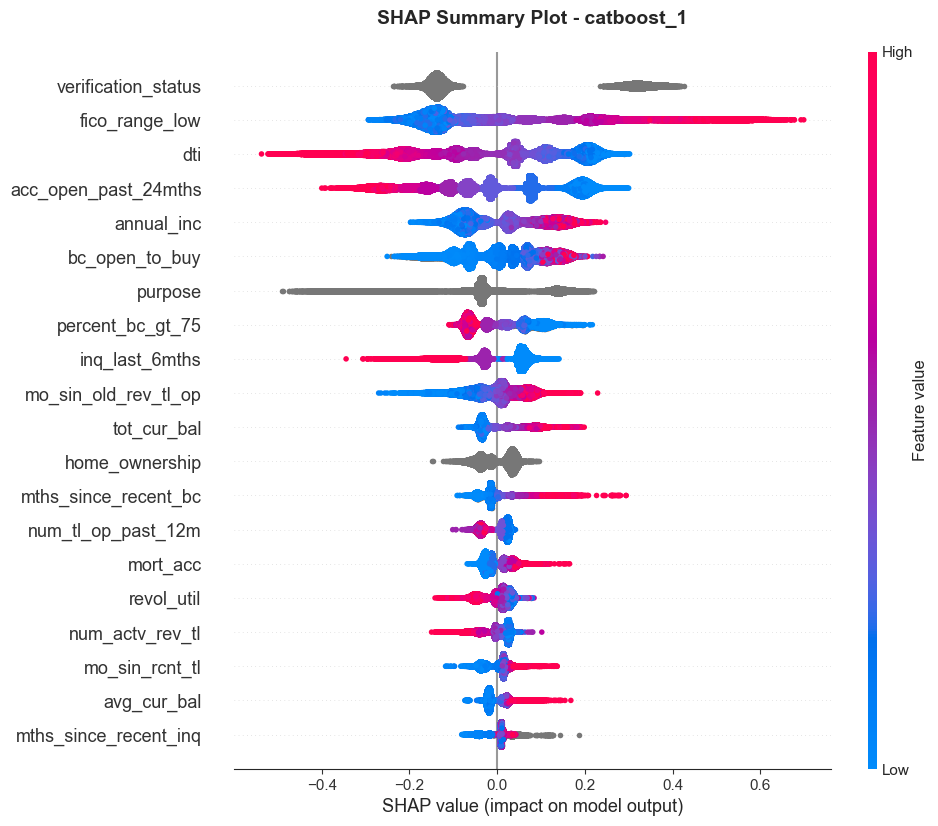

   ✅ Completado: catboost_1

🔍 Procesando: catboost_2 (Experimento 2)
   - Algoritmo: catboost
   - Features: 61 (57 numéricas, 4 categóricas)
   - Usando todos los 236008 registros
   - Calculando SHAP values...
   - Generando summary plot...
   ✅ Plot guardado: ../plots/shap_summary_round01/shap_summary_catboost_2.png


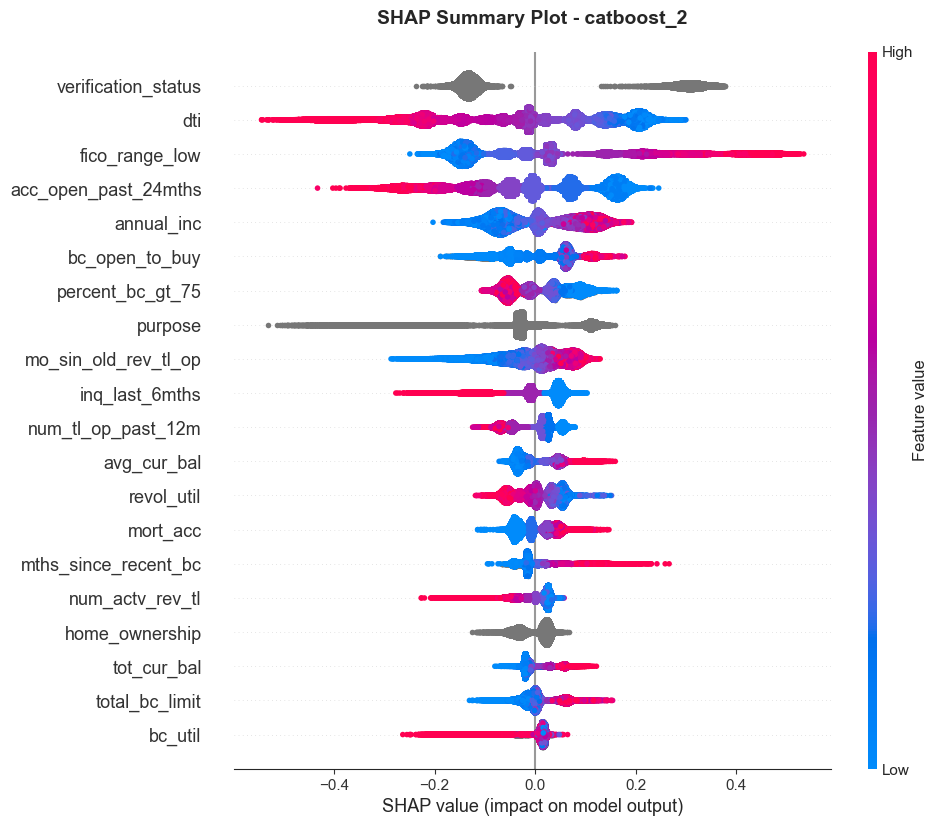

   ✅ Completado: catboost_2

🔍 Procesando: catboost_3 (Experimento 3)
   - Algoritmo: catboost
   - Features: 61 (57 numéricas, 4 categóricas)
   - Usando todos los 236008 registros
   - Calculando SHAP values...
   - Generando summary plot...
   ✅ Plot guardado: ../plots/shap_summary_round01/shap_summary_catboost_3.png


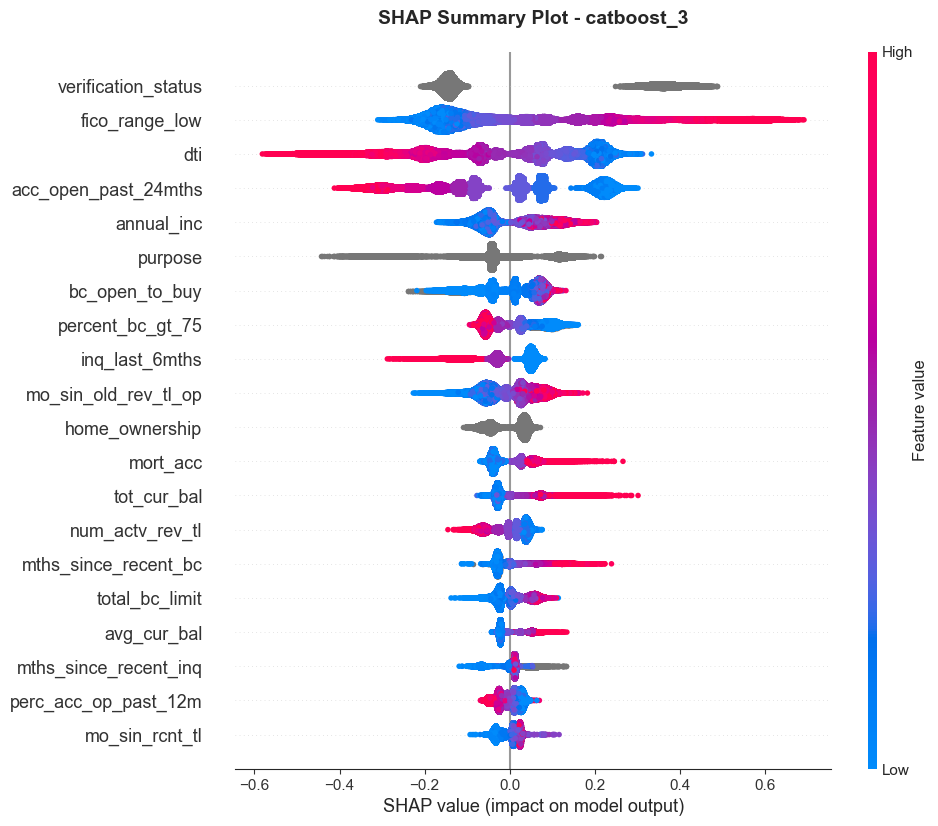

   ✅ Completado: catboost_3

🔍 Procesando: catboost_4 (Experimento 4)
   - Algoritmo: catboost
   - Features: 61 (57 numéricas, 4 categóricas)
   - Usando todos los 236008 registros
   - Calculando SHAP values...
   - Generando summary plot...
   ✅ Plot guardado: ../plots/shap_summary_round01/shap_summary_catboost_4.png


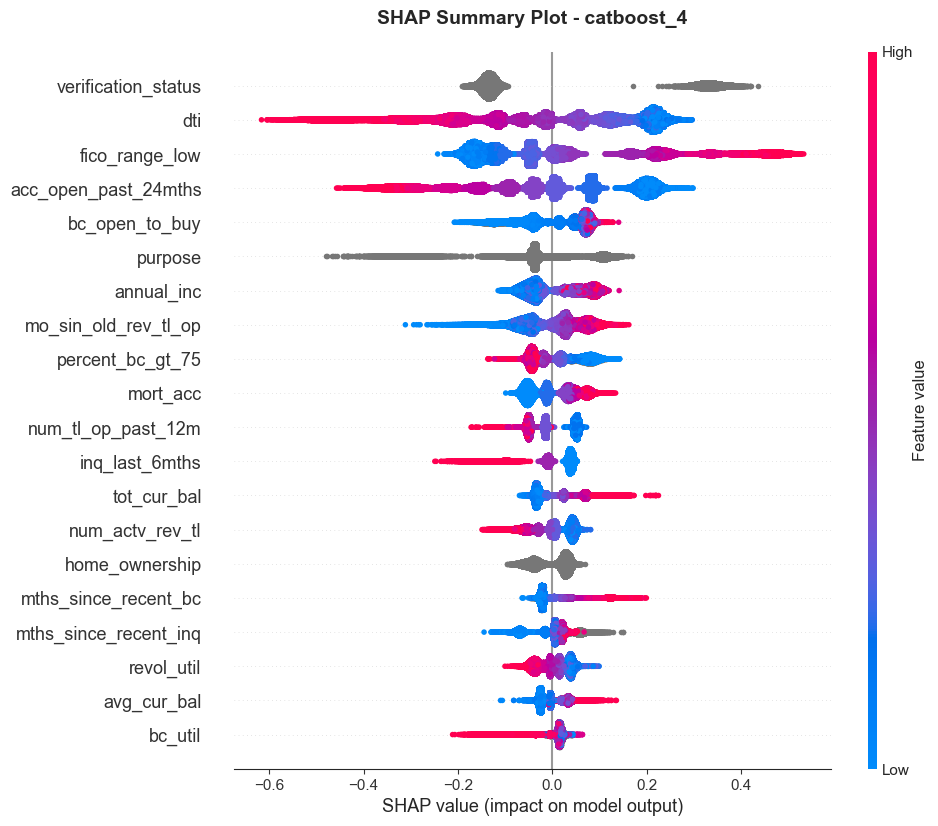

   ✅ Completado: catboost_4

✅ Proceso completado. SHAP calculado para 4 experimentos


In [15]:
shap_results = calculate_shap_summary_plots(
     experiments_list=experiments_01,
     resultados_comparativos=results_from_pickle,
     df_data=df_pop,  # DataFrame con los datos para calcular SHAP
     sample_size=df_pop.shape[0],  # Usar 1000 muestras (ajustar según necesidad)
     save_path='../plots/shap_summary_round01',  # Guardar plots
     show_plots=True  # Mostrar en notebook
 )


- In general, all features's behaviour and relation with the score, make sense to me, but there are some that we should make zoom to check if are alined with the data. Thake for example, `verification_status` 

In [16]:
shap_by_category_all['catboost_4']['verification_status']

category
Source Verified   -0.137350
Verified          -0.133899
Not Verified       0.331585
Name: shap_value, dtype: float64

- Since the model is trained to predict payment (target = 1), positive SHAP values indicate an increased probability of repayment, while negative SHAP values indicate a lower probability of repayment and therefore higher risk.

- For `verification_status`, the category “Not Verified” shows a strong positive SHAP contribution, indicating a higher predicted probability of payment. In contrast, “Verified” and “Source Verified” are associated with negative SHAP values, reducing the predicted probability of payment.

- For me this is contraintuitive, so I would need to check with the data directly

In [20]:
df_old02.groupby(['verification_status']).agg({'is_paid_strict':'mean', 'id':'count'})

,is_paid_strict,id
verification_status,,
Not Verified,0.861317,192564
Source Verified,0.795370,287112
Verified,0.766822,199181


- The feature does have that relationship with the target variable, so we're seeing what it learn from

- About other features:

    - `dti`: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
        - The shaps (red=greater feature = has lower score / blue=lower feature =has greater score) make sense that, as greater the feature, lower the score, because it would be telling us that the client is using a bigger percentage of his monthly income, therefore it would be more problematic to him to pay us.

    - `fico_range_low`: We can see that, greater fico-scores, have greater our-score, which make sense with the payment behaviour, since we expect having the greatest scores for clientes that pay better.

    - `acc_open_past_24mths`: Number of trades opened in past 24 months.
    It could make sense to me that, when a client has oppened more trades (accounts??) "lately", maybe that could mean that is trying to pay one with another and then again and again and againg and that could make him/her not paying us

    - `bc_open_to_buy`: Total open to buy on revolving bankcards.
    We can see that as greater the feature, greater the score. Which also make sense because that could mean that the client has available a big amount of his/hers credit limit, which could tell us that has some capacity to pay us.

In [17]:
shap_by_category_all['catboost_4']['home_ownership']

category
RENT       -0.043280
ANY        -0.003546
OWN         0.025218
MORTGAGE    0.028218
Name: shap_value, dtype: float64

In [19]:
df_old02.groupby(['home_ownership']).agg({'is_paid_strict':'mean', 'id':'count'})

,is_paid_strict,id
home_ownership,,
ANY,1.000000,3
MORTGAGE,0.830047,335096
OWN,0.802449,72181
RENT,0.776579,271577


#hola

# Final Thoughts and Next Steps

- Also, in case of be able to identify the Control Group, the tests should be repeted only with it.

- In that case, an extra visualization could have place: swap in/swap out, which shows the metrics (LR, DR, profit) in four universes:
    - loans accepted for both models (champion and challenger)
    - loans rejected for both models (champion and challenger)
    - loans accepted for champion and rejected for challenger
    - loans accepted for challenger and rejected for champion

- That would tell us, among other things, if the true negative rate increases and the false positive rate decreases with the new model.

- Nevertheless, in order to not be a blocker I would recomend to the stakeholders to go forward with the experiment `catboost_04` as a challenger, since all the metrics show that is better than the champion and, at the same time, the features behaviour make sense with the target.

- I would recommend also to implement it as an A/B Test for a period of time that suits for all teams involve, specially to bussines,

- If the metrics, after that time, confirm what we just saw, we could go with the complete roll out

- At the same time, if there is not hurry to have a new model already and there could still be some time for new iterations, I would like to run some extra experiments to include some of the feature we mentioned, like the related with job title (`emp_title`), try with xgb and lgbm and confirm if the features I took out of the features for possible leakage (because I interpretated that those weren't at origination) were well decided and if not, include the features that I wrongly left out and run again the experiments to check if any of these ideas could improve the performance.